## Nom des membres de l'équipe:

### Nom, Prénom :  NI 
### Légaré, Ophélie : 111 182 608
### Parrot, Anaïs : 111 184 980
### Turgeon, David : 111 182 265

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sciPy as sp

Introduction : 

La radiothérapie externe est une méthode employée notamment dans le domaine de la radio-oncologie au CHUM pour le traitement du cancer. La radiothérapie externe traite les tumeurs au moyen de faisceaux de rayons-X, d'électrons ou de hadrons. La protonthérapie, quant à elle, est une branche spécifique de la radiothérapie visant à traiter les tumeurs peu profondes telles que les mélanomes oculaires à l'aide de faisceaux de protons de faible énergie. Cette technique permet d'optimiser la ballistique du faisceau afin de cibler la tumeur tout en épargnant les tissus sains.

Dans cette étude, on cherche à planifier et prédire la dose reçue par un patient suivant un traitement de protonthérapie. Pour ce faire, la portée des protons dans la matière est déterminée à l'aide de méthodes d'intégration numérique; soit la méthode des trapèzes et la méthode de Simpson. Par la suite, les algorithmes sont comparés à une distribution de Moyal. Le calcul de l'énergie déposée par le faisceau de proton à la tumeur est réalisé à partir de son énergie cinétique. Finalement, le réalisme du modèle d'intégration numérique développé est discuté.

Équations utiles :

Pouvoir d'arrêt collisionnel massique :

\begin{align}
\frac{S_{col}}{\rho} = -\left(\frac{dT}{\rho dx}\right) = NZ\int^{T_e^{max}}_0 T \left(\frac{d\sigma}{dT'}\right)_{col}dT'
\end{align}

L'énergie maximale transférable à un électron par le proton:

\begin{align}
T_e^{max} = \frac{2m_ec^2(\gamma^2-1)}{1+2\gamma\frac{m_e}{m_p}+\left(\frac{m_e}{m_p}\right)^2}
\end{align}

Pouvoir d'arrêt collisionnel pour les protons:

\begin{align}
-\left(\frac{dT}{dx}\right)_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{Z^2}{\beta^2}\left [\ln\left(\frac{2m_e c^2(\gamma^2-1)T_e^{max}}{I^2} \right)-\delta+\\
2(-\beta^2-\frac{C}{Z}+ZL_1+Z^2L_2)\right]
\end{align}

Pouvoir d'arrêt collisionnel pour protons de plus de 3 MeV (termes correctifs négligés):

\begin{align}
S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left [\ln\left(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]
\end{align}

Portée des protons en ligne droite dans la matière:

\begin{align}
R_{CSDA} = \int^{T_i}_0 \frac{dT'}{\frac{S_{col}}{\rho}}
\end{align}

Énergie déposée pour un déplacement d'un proton s dans un milieu:

\begin{align}
s = \int^{T_i}_{T_f} \frac{dT'}{S_{col}}
\end{align}

Les différentes variables utilisées sont :

- r_e le rayon classique de l'électron
- n_e la densité électronique du matériaux
- Z la charge de la particule (Z = 1 pour les protons)
- N le nombre d'atome par gramme
- T' l'énergie transféré à l'électron de l'atome
- I l'énergie moyenne d'excitation du matériau,
- $\frac{d\sigma}{dT}$ section efficace différentielle pour les collision inélastique d'une énergie transféee T',
- $\beta$ et $\gamma$ sont les facteurs de Lorentz,
- $\delta$ un terme considérant les effets de la polarisation,
- $2\frac{C}{Z}$ corrige les effet du modèle en couche du cortège électronique atomique
- ZL$_1$ est la correction de Barkas
- Z^2L$_2$ est la correction de Bloch


Question 1 :

La densité électronique d'un milieu peut être exprimée en fonction de sa composition atomique et de sa masse volumique à l'aide de l'équation suivante,

\begin{align}
n_e = \frac{N_A Z \rho}{A M_u} = 0.6022x10^{24} \frac{Z \rho}{A},
\end{align}

où N_A est le nombre d'Avogadro, Z est le numéro atomique, \rho est la densité, A est la masse atomique relative et M_u est la  masse molaire. L'eau liquide et l'os compact (ICRU) sont des composés donc le numéro atomique et la masse atomique de chacun des éléments qui les composent sont pondérés selon leur fraction massique respective.

In [29]:
def calcule(p,Z_1,A_1,Z_8,A_8):
    n_eau = (0.6022*10**(24))*p*(0.111894*(Z_1/A_1)+0.888106*(Z_8/A_8))
    return n_eau
print(calcule(1.00000,1,1.00794,8,15.9994))

3.342705085983941e+23


In [24]:
def calcule(p,Z_1,A_1,Z_6,A_6,Z_7,A_7,Z_8,A_8,Z_12,A_12,Z_15,A_15,Z_16,A_16,Z_20,A_20):
    n_os = (0.6022*10**(24))*p*(0.063984*(Z_1/A_1)+0.278000*(Z_6/A_6)+0.027000*(Z_7/A_7)+0.410016*(Z_8/A_8)+0.002000*(Z_12/A_12)+0.070000*(Z_15/A_15)+0.002000*(Z_16/A_16)+0.147000*(Z_20/A_20))
    return n_os
print(calcule(1.85000,1,1.00794,6,12.0107,7,14.0067,8,15.9994,12,24.3050,15,30.973762,16,32.065,20,40.078))

5.90576758009253e+23


L'énergie moyenne d'excitation de l'eau liquide est de 75.000000 eV et celle de l'os compact (ICRU) est de 91.900000 eV. Les courbes des pouvoirs d'arrêt collisionnel de l'eau liquide et de l'os compact sont pprésentées ci-dessous avec une échelle logarithmique en abscisse.

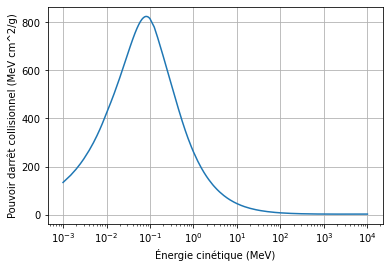

In [52]:
from numpy import loadtxt
eau_energy = loadtxt("./eau.txt", float)
#print(eau_energy)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(eau_energy[:,0],eau_energy[:,1])
plt.xlabel("Énergie cinétique (MeV)")
plt.ylabel('Pouvoir d''arrêt collisionnel (MeV cm^2/g)')
plt.grid(True)
plt.xscale('log')
plt.show()

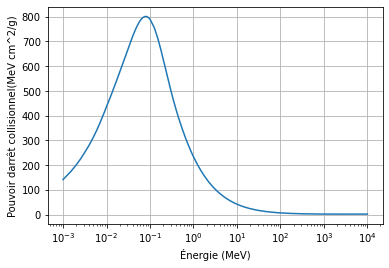

In [50]:
from numpy import loadtxt
bone_energy = loadtxt("./bone.txt", float)
#print(bone_energy)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(bone_energy[:,0],bone_energy[:,1])
plt.xlabel("Énergie cinétique (MeV)")
plt.ylabel('Pouvoir d''arrêt collisionnel (MeV cm^2/g)')
plt.grid(True)
plt.xscale('log')
plt.show()

Question 6 :

L'expression analytique de la dérivée du pouvoir d'arrêt collisionnel est obtenue avec les simplifications et substitutions suggérées dans l'énoncé. On obtient l'équation suivante.

\begin{align}
-\left(\frac{dT}{dx}\right)_{col} = U \frac{Z^2}{\beta^2}\left [\ln\left(\frac{k\gamma^4\beta^4}{\gamma\delta+b}\right)-\delta+
2(-\beta^2-\frac{C}{Z}+ZL_1+Z^2L_2)\right]
\end{align}    